In [ ]:
'''
目前預想:
  用都沒挑的當基底
  純用統計
  統計加基因
  純基因

model:
  SVC with bagging (estimator = 30 or 100?)
  XGB
  RF (也許可以用 rfpimp避免多重共線性?)

比較就主採 test auc -> acc -> MCC
'''

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **package & function**

In [2]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 4.66 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.7 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pynvml/nvml.py", line 1798, in _LoadNvmlLibrary
    nvmlLib = CDLL("libnvidia-ml.so.1")
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: libnvidia-ml.so.1: cannot open shared object file: No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call la

In [3]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 4.5 MB/s eta 0:00:00


In [6]:
#------------------------| normal |--------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random

#---------------------| processsing |------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import math

#------------------------| model |---------------------------
import cuml
import cudf
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.svm import SVC as cuSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

#------------------------| deap |-----------------------------
from deap import tools
from deap import creator
from deap import base
from deap import algorithms

#---------| hyperparameter & feature selecting |----------
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from bayes_opt import BayesianOptimization

#---------------------| evaluation |-------------------------
from xgboost import plot_importance
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

In [7]:
def std(x_train):
  Std = preprocessing.StandardScaler().fit(x_train)
  x_train_Std = Std.transform(x_train)

  return x_train_Std

In [9]:
def ROC_and_AUC(label, score, name):
    
    fpr, tpr , _ = roc_curve(label, score)
    roc_auc = auc(fpr, tpr)
    name = name + '_auc = ' + str(roc_auc.round(3))
    lw = 2
    plt.plot(fpr, tpr, lw = lw, label = name)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = "lower right")

In [10]:
def model_evaluation_result(X_train_Std, y_train, X_test_Std, y_test, model, roctrainname, roctestname):
    
    model.fit(X_train_Std, y_train)
    
    train_pred = model.predict(X_train_Std)
    score_train = model.decision_function(X_train_Std)
    train_acc = accuracy_score(y_train, train_pred)
    tn, fp, fn, tp = confusion_matrix(y_train, train_pred).ravel()
    train_specificity = tn / (tn+fp)
    train_sensitivity = tp / (tp+fn)
    train_PPV = tp / (tp+fp)
    train_NPV = tn / (fn+tn)
    train_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_train, score_train, roctrainname)

    test_pred = model.predict(X_test_Std)
    score_test = model.decision_function(X_test_Std)
    test_acc = accuracy_score(y_test, test_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
    test_specificity = tn / (tn+fp)
    test_sensitivity = tp / (tp+fn)
    test_PPV = tp / (tp+fp)
    test_NPV = tn / (fn+tn)
    test_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_test, score_test, roctestname)
    result = [{'Accuracy': train_acc,'Specificity': train_specificity, 'Sensitivity': train_sensitivity, 'MCC': train_MCC, 'PPV': train_PPV, 'NPV': train_NPV},
          {'Accuracy': test_acc,'Specificity': test_specificity, 'Sensitivity': test_sensitivity, 'MCC': test_MCC, 'PPV': test_PPV, 'NPV': test_NPV}]
    result_df = pd.DataFrame(result)
    result_df.index = ['Training set', 'Test_set']
    result_df = result_df.round(3)
    print(result_df)
    return result_df, score_train, train_pred, score_test, test_pred, model

In [11]:
def confusion_matrix_scorer(clf, X, y):
  y_pred = clf.predict(X)
  cm = confusion_matrix(y, y_pred)
  return {'tn': cm[0, 0], 'fp': cm[0, 1],'fn': cm[1, 0], 'tp': cm[1, 1]}

In [12]:
def proba_model_evaluation_result(X_train_Std, y_train, X_test_Std, y_test, model, roctrainname, roctestname):
    
    model.fit(X_train_Std, y_train)
    
    train_pred = model.predict(X_train_Std)
    score_train = model.predict_proba(X_train_Std)
    train_acc = accuracy_score(y_train, train_pred)
    tn, fp, fn, tp = confusion_matrix(y_train, train_pred).ravel()
    train_specificity = tn / (tn+fp)
    train_sensitivity = tp / (tp+fn)
    train_PPV = tp / (tp+fp)
    train_NPV = tn / (fn+tn)
    train_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_train, score_train[:, 1], roctrainname)

    test_pred = model.predict(X_test_Std)
    score_test = model.predict_proba(X_test_Std)
    test_acc = accuracy_score(y_test, test_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
    test_specificity = tn / (tn+fp)
    test_sensitivity = tp / (tp+fn)
    test_PPV = tp / (tp+fp)
    test_NPV = tn / (fn+tn)
    test_MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    ROC_and_AUC(y_test, score_test[:, 1], roctestname)
    result = [{'Accuracy': train_acc,'Specificity': train_specificity, 'Sensitivity': train_sensitivity, 'MCC': train_MCC, 'PPV': train_PPV, 'NPV': train_NPV},
          {'Accuracy': test_acc,'Specificity': test_specificity, 'Sensitivity': test_sensitivity, 'MCC': test_MCC, 'PPV': test_PPV, 'NPV': test_NPV}]
    result_df = pd.DataFrame(result)
    result_df.index = ['Training set', 'Test_set']
    result_df = result_df.round(3)
    print(result_df)
    return result_df, score_train, train_pred, score_test, test_pred, model

In [13]:
def pointer(model, x_train, y_train):
  cv_results = cross_validate(model, x_train, y_train, cv = 5, scoring = confusion_matrix_scorer)
  tn = round(cv_results['test_tn'].mean())
  fp = round(cv_results['test_fp'].mean())
  fn = round(cv_results['test_fn'].mean())
  tp = round(cv_results['test_tp'].mean())
  accuracy = (tp+tn)/(tn+fp+fn+tp)
  precision = tp/(tp+fp)
  sensitivity = tp/(tp+fn)
  specificity = tn/(tn+fp)
  MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
  print("TN_result: ", cv_results['test_tn'], " TN_mean: ", round(cv_results['test_tn'].mean()))
  print("FP_result: ",cv_results['test_fp']," FP_result: ", round(cv_results['test_fp'].mean()))
  print("FN_result: ",cv_results['test_fn']," FN_result: ", round(cv_results['test_fn'].mean()))
  print("TP_result: ",cv_results['test_tp']," TP_result: ", round(cv_results['test_tp'].mean()))
  print('accuracy:', accuracy)
  print('precision:', precision)
  print('sensitivity:', sensitivity)
  print('specificity:', specificity)
  print('MCC:', MCC)

In [14]:
def confusion_matrix_(actual, predict):
  sns.set()
  f,ax = plt.subplots()
  cm = confusion_matrix(actual, predict)
  sns.heatmap(cm, annot=True, ax = ax)

  ax.set_title('confusion matrix') 
  ax.set_xlabel('predict') 
  ax.set_ylabel('true') 

# **data**

In [15]:
rd = pd.read_csv("/content/drive/MyDrive/BinaryClassifier_4weeks_data_v2.csv")

In [16]:
from collections import Counter
label_count = Counter(rd["label"])
print("label count:", label_count)

label count: Counter({0: 5441, 1: 1643})


In [17]:
x = rd.iloc[:, 0:-1]
y = rd.iloc[:, -1]

sss = StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=0)
for train_index, test_index in sss.split(x, y):
  print("TRAIN:", train_index, "TEST:", test_index)
  x_train, x_test = x.iloc[train_index,:], x.iloc[test_index,:]
  y_train, y_test = y[train_index], y[test_index]

TRAIN: [6825 4238 5432 ... 2254 5098 3772] TEST: [5047 2899 6715 ... 6712 1338 6977]


In [18]:
# c_idx = []
# d_idx = []
# idx = 0
# for i in rd.columns:
#   if(i[0] == 'd'): d_idx.append(idx)
#   elif(i[0] == 'c'): c_idx.append(idx)
#   idx += 1

In [19]:
# d = x_train.iloc[:, d_idx]
# c = x_train.iloc[:, c_idx]

In [20]:
# d_s = pd.concat([d, y_train], axis = 1)
# d_prefeature = []
# p_value = []
# d_s = d_s[d_s['label'] >= 0]
# columns = list(d_s.columns)
# for i in columns:
#     table = pd.crosstab(d_s['label'], d_s[i])
#     chi2, p, dof, expected = chi2_contingency(table)
#     p_value.append(p)
#     if p < 0.05:
#       d_prefeature.append(i)

# d_p_value = pd.DataFrame([columns, p_value]).T
# d_p_value = d_p_value.rename(columns = {0:'features', 1:'p_value'})
# print(d_p_value)
# print(d_prefeature[0:-1])

In [21]:
# c_s = pd.concat([c, y_train], axis = 1)

# c_s = c_s[c_s['label'] >= 0]
# columns = list(c_s.columns)
# c_prefeature = []
# p_value = []
# for i in columns:
#     value1=[]
#     value0=[]
#     my_col = c_s[[i,'label']]
#     for j in range(0, my_col.shape[0]):
#         if (str(my_col.iloc[j,1]) == '1'):
#             value1.append(my_col.iloc[j,0])
#         elif (str(my_col.iloc[j,1]) == '-1'):
#             continue
#         else:
#             value0.append(my_col.iloc[j,0])
#     result = mannwhitneyu(value0, value1, alternative= 'two-sided') 
#     p_value.append(result[1])
    
#     if result[1] < 0.05:
#       c_prefeature.append(i)

# c_p_value = pd.DataFrame([columns, p_value]).T
# c_p_value = c_p_value.rename(columns = {0:'features', 1:'p_value'})
# print(c_p_value)
# print(c_prefeature[0:-1])

In [22]:
#prefeature = d_prefeature[0:-1] + c_prefeature[0:-1] 下面的feature跟這行的一樣，這樣就不用再跑一次統計方法(很久)
prefeature = ['d3','d4','d5','d6','d7','d8','d9','d11','d12','d14','d15','d20','d21','d22','d23','d26','d27','d28','d29','d30','d31','d32','d33','d34','d37','d39','d500','c45','c47','c49','c50','c51','c53','c55','c56','c57','c58','c59','c60','c62','c64','c65','c66','c70','c71','c72','c73','c74','c75','c78','c79','c80','c82','c83','c84','c86','c89','c90','c95','c96','c98','c100','c101','c102','c104','c106','c107','c108','c110','c111','c113','c115','c116','c117','c118','c121','c122','c123','c124','c125','c126','c129','c130','c131','c133','c134','c135','c137','c140','c141','c146','c147','c148','c149','c151','c152','c153','c155','c157','c158','c159','c160','c161','c162','c164','c166','c167','c168','c169','c172','c173','c174','c175','c176','c177','c179','c180','c181','c182','c184','c185','c186','c188','c191','c192','c201','c207','c214','c217','c222','c225','c228','c229','c252','c258','c260','c263','c268','c270','c273','c274','c277','c279','c281','c284','c303','c309','c331','c332','c345','c354','c356','c360','c362','c365','c372','c376','c379','c405','c432','c437','c501','c502','c503','c504','c507']
x_pretrain = x_train.loc[:, prefeature]
x_pretest = x_test.loc[:, prefeature]
y_train = y_train
y_test = y_test

In [23]:
x_pretrain_std = std(x_pretrain)
x_pretest_std = std(x_pretest)

In [24]:
x_pretrain_std = pd.DataFrame(x_pretrain_std)
x_pretest_std = pd.DataFrame(x_pretest_std)

x_pretrain_std.columns = prefeature
x_pretrain_std.index = train_index
x_pretest_std.columns = prefeature
x_pretest_std.index = test_index

# **nothing**

In [ ]:
feature = x_train.columns
x_rdt_std = std(x_train)
x_rds_std = std(x_test)

In [ ]:
x_rdt_std = pd.DataFrame(x_rdt_std)
x_rds_std = pd.DataFrame(x_rds_std)

x_rdt_std.columns = feature
x_rds_std.columns = feature

**SVC**

              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     0.830        0.985        0.317  0.456  0.861  0.827
Test_set         0.786        0.972        0.168  0.248  0.643  0.795


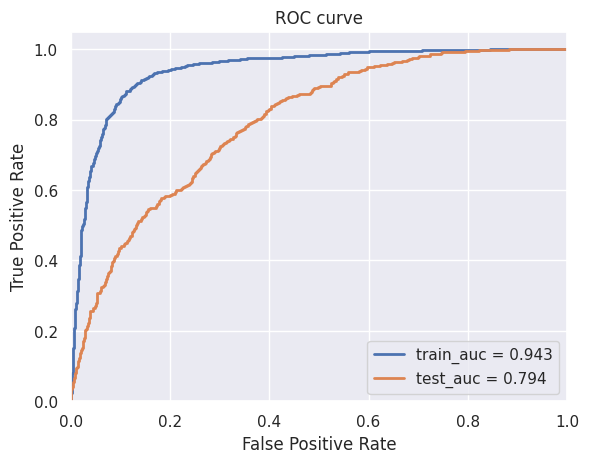



TN_result:  [750 751 749 730 747]  TN_mean:  745
FP_result:  [12 11 13 31 14]  FP_result:  16
FN_result:  [200 203 199 195 203]  FN_result:  200
TP_result:  [30 27 31 35 27]  TP_result:  30
accuracy: 0.7820383451059536
precision: 0.6521739130434783
sensitivity: 0.13043478260869565
specificity: 0.9789750328515112
MCC: 0.21954204830631707




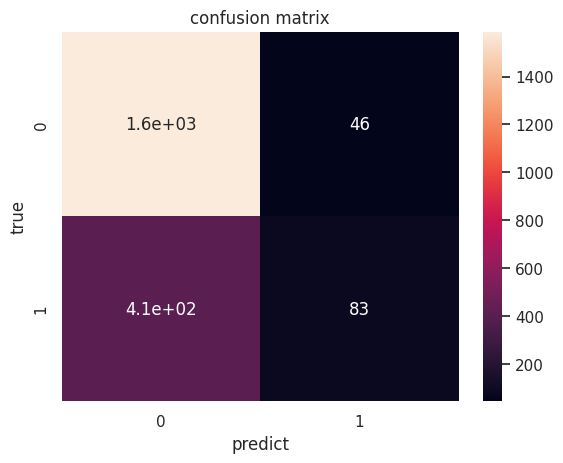

In [ ]:
svm = SVC(kernel = "rbf")
svc_model = BaggingClassifier(estimator=svm, n_estimators = 100)

plt.figure()
df_svc, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = model_evaluation_result(x_rdt_std, y_train, x_rds_std, y_test, svc_model, 'train', 'test')
plt.show()

print("\n")
pointer(svc_model, x_rdt_std, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

**XGB**

              Accuracy  Specificity  Sensitivity   MCC    PPV    NPV
Training set     1.000        1.000        1.000  1.00  1.000  1.000
Test_set         0.881        0.948        0.659  0.65  0.793  0.902


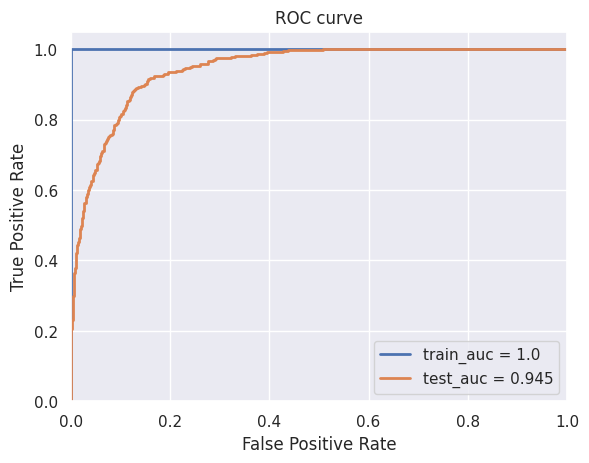



TN_result:  [721 722 713 718 725]  TN_mean:  720
FP_result:  [41 40 49 43 36]  FP_result:  42
FN_result:  [78 75 63 72 85]  FN_result:  75
TP_result:  [152 155 167 158 145]  TP_result:  155
accuracy: 0.8820564516129032
precision: 0.7868020304568528
sensitivity: 0.6739130434782609
specificity: 0.9448818897637795
MCC: 0.6545931785595676




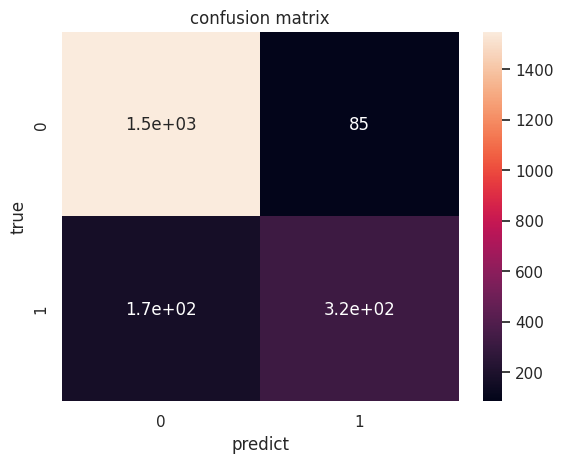

In [ ]:
xgb = XGBClassifier()

plt.figure()
df_svc, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(x_rdt_std, y_train, x_rds_std, y_test, xgb, 'train', 'test')
plt.show()

print("\n")
pointer(xgb, x_rdt_std, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

**RF**

              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     1.000        1.000        1.000  1.000  1.000  1.000
Test_set         0.871        0.969        0.544  0.607  0.843  0.876


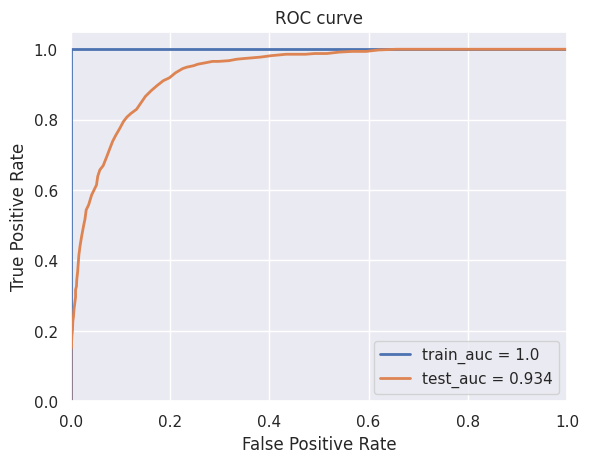



TN_result:  [729 731 720 726 729]  TN_mean:  727
FP_result:  [33 31 42 35 32]  FP_result:  35
FN_result:  [112  95 100  95  95]  FN_result:  99
TP_result:  [118 135 130 135 135]  TP_result:  131
accuracy: 0.8649193548387096
precision: 0.7891566265060241
sensitivity: 0.5695652173913044
specificity: 0.9540682414698163
MCC: 0.5920041144406432




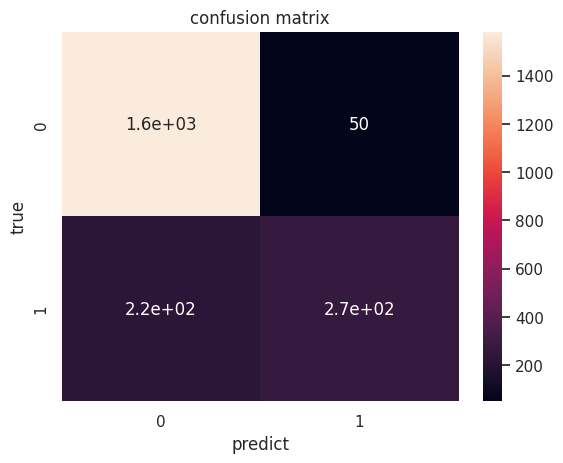

In [ ]:
rf = RandomForestClassifier()

plt.figure()
df_svc, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(x_rdt_std, y_train, x_rds_std, y_test, rf, 'train', 'test')
plt.show()

print("\n")
pointer(rf, x_rdt_std, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

# **only statistic**

**SVC**

In [ ]:
def svc_function(C, gamma):
    m = SVC(kernel = "rbf", C = C, gamma = gamma)
    mean_score = cross_val_score(m, x_pretrain_std, y_train, cv = 5, scoring = "roc_auc").mean()
    
    return mean_score

In [ ]:
pbounds = {
    'C': [0.0078125, 256],
    'gamma': [0.0078125, 256]
}
svc_optimizer = BayesianOptimization(f = svc_function, pbounds = pbounds)

svc_optimizer.maximize(n_iter = 300)

In [ ]:
svc_optimizer.max

{'target': 0.8935633696390705,
 'params': {'C': 32.13162009624968, 'gamma': 0.0078125}}

              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     0.982        0.991        0.953  0.950  0.970  0.986
Test_set         0.859        0.918        0.663  0.595  0.709  0.900


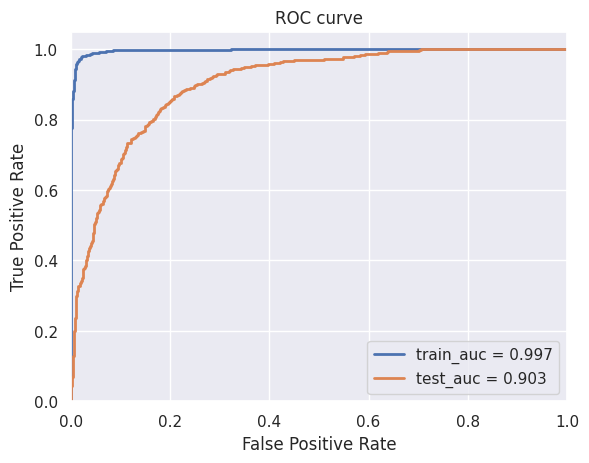



TN_result:  [699 701 693 704 693]  TN_mean:  698
FP_result:  [63 61 69 57 68]  FP_result:  64
FN_result:  [95 79 69 81 90]  FN_result:  83
TP_result:  [135 151 161 149 140]  TP_result:  147
accuracy: 0.8518145161290323
precision: 0.6966824644549763
sensitivity: 0.6391304347826087
specificity: 0.916010498687664
MCC: 0.5725031893548181




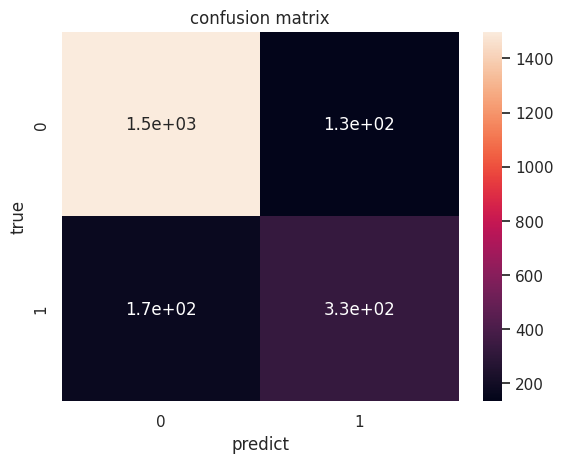

In [ ]:
svm = SVC(kernel = "rbf", C = 32.13162009624968, gamma = 0.0078125)
svc_model = BaggingClassifier(estimator=svm, n_estimators = 100, n_jobs = -1)

plt.figure()
df_svc, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = model_evaluation_result(x_pretrain_std, y_train, x_pretest_std, y_test, svc_model, 'train', 'test')
plt.show()

print("\n")
pointer(svc_model, x_pretrain_std, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

**XGB**

In [ ]:
def xgb_function(n_estimators, max_depth, learning_rate, gamma):
    m = XGBClassifier(n_estimators = int(n_estimators), max_depth = int(max_depth), learning_rate = learning_rate, gamma = gamma)
    mean_score = cross_val_score(m, x_pretrain_std, y_train, cv = 5, scoring = "roc_auc").mean()
    
    return mean_score

In [ ]:
pbounds = {
    'n_estimators':[100, 500],
    'max_depth': [10, 60],
    'learning_rate': [0.01, 3],
    'gamma': [0.015625, 128]
}
xgb_optimizer = BayesianOptimization(f = xgb_function, pbounds = pbounds)

xgb_optimizer.maximize(n_iter = 300)

In [ ]:
xgb_optimizer.max

{'target': 0.9621020228553245,
 'params': {'gamma': 0.6894903888318535,
  'learning_rate': 0.2749218496878777,
  'max_depth': 47.86651040794286,
  'n_estimators': 124.90230343161514}}

              Accuracy  Specificity  Sensitivity    MCC   PPV    NPV
Training set      1.00        1.000        1.000  1.000  1.00  1.000
Test_set          0.92        0.965        0.771  0.769  0.87  0.933


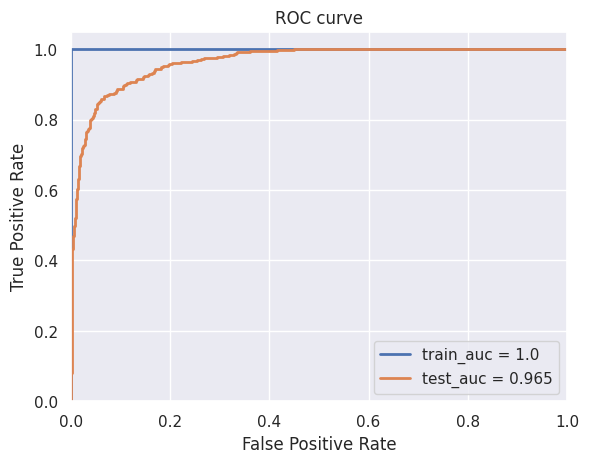



TN_result:  [742 731 724 725 727]  TN_mean:  730
FP_result:  [20 31 38 36 34]  FP_result:  32
FN_result:  [51 49 51 56 53]  FN_result:  52
TP_result:  [179 181 179 174 177]  TP_result:  178
accuracy: 0.9153225806451613
precision: 0.8476190476190476
sensitivity: 0.7739130434782608
specificity: 0.958005249343832
MCC: 0.7561204452300182




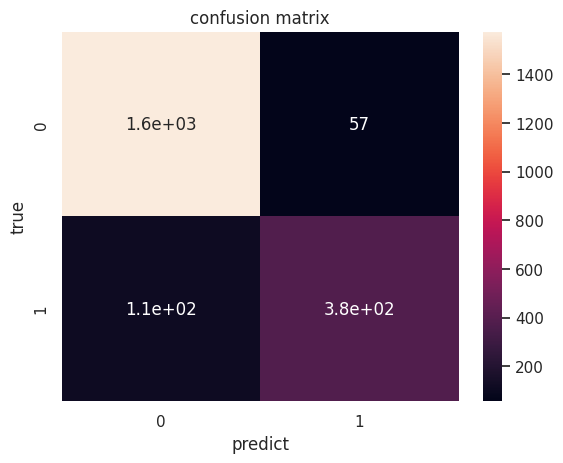

In [ ]:
xgb_model = XGBClassifier(gamma = 0.6894903888318535, learning_rate = 0.2749218496878777, max_depth = 47, n_estimators = 124)

plt.figure()
df_xgb, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(x_pretrain_std, y_train, x_pretest_std, y_test, xgb_model, 'train', 'test')
plt.show()

print("\n")
pointer(xgb_model, x_pretrain_std, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

**RF**

In [ ]:
def rf_function(n_estimators, max_depth, min_samples_leaf, min_samples_split):
    m = RandomForestClassifier(n_estimators = int(n_estimators), max_depth = int(max_depth), criterion = "gini", min_samples_leaf = int(min_samples_leaf), min_samples_split = int(min_samples_split))
    mean_score = cross_val_score(m, x_pretrain_std, y_train, cv = 5, scoring = "roc_auc").mean()
    
    return mean_score

In [ ]:
pbounds = {
    'max_depth': [10, 70],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 8],
    'n_estimators': [100, 500]
}
rf_optimizer = BayesianOptimization(f = rf_function, pbounds = pbounds)

rf_optimizer.maximize(n_iter = 300)

In [ ]:
rf_optimizer.max

{'target': 0.955897171283573,
 'params': {'max_depth': 48.70429606621174,
  'min_samples_leaf': 1.0,
  'min_samples_split': 2.0,
  'n_estimators': 419.4386305002588}}

              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     1.000        1.000        1.000  1.000  1.000  1.000
Test_set         0.913        0.969        0.726  0.744  0.875  0.921


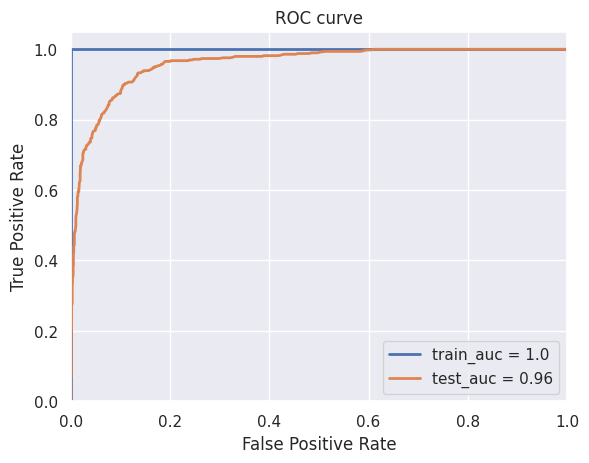



TN_result:  [735 735 718 728 729]  TN_mean:  729
FP_result:  [27 27 44 33 32]  FP_result:  33
FN_result:  [79 54 61 72 66]  FN_result:  66
TP_result:  [151 176 169 158 164]  TP_result:  164
accuracy: 0.9002016129032258
precision: 0.8324873096446701
sensitivity: 0.7130434782608696
specificity: 0.9566929133858267
MCC: 0.7084816792343469




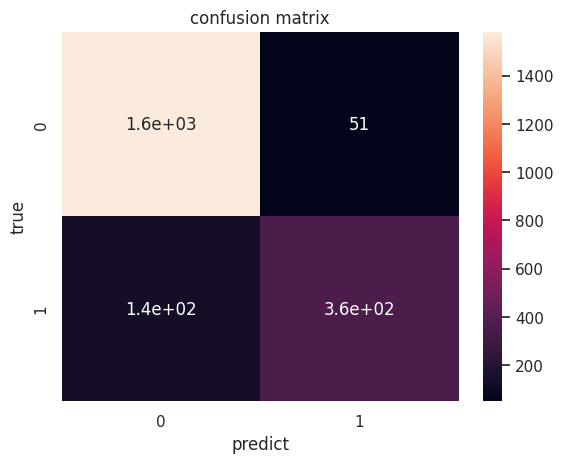

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 419, max_depth = 48, criterion = "gini", min_samples_leaf = 1, min_samples_split = 2)
rf_model.fit(x_pretrain_std, y_train)
plt.figure()
df_rf, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(x_pretrain_std, y_train, x_pretest_std, y_test, rf_model, 'train', 'test')
plt.show()

print("\n")
pointer(rf_model, x_pretrain_std, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

# **SGA**

In [ ]:
class SGA:
  def __init__(self, model, x_train, y_train, toolbox = None, stats = None, ind_size = None, best_feature = None):
    self.model = model
    self.x_train = x_train
    self.y_train = y_train
    self.toolbox = toolbox
    self.stats = stats
    self.ind_size = ind_size
    self.best_feature = best_feature

  def build(self):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    self.ind_size = self.x_train.shape[1]

    self.toolbox = base.Toolbox()
    self.toolbox.register("attrib_bin", random.randint, 0, 1)
    self.toolbox.register("individual", tools.initRepeat, creator.Individual, self.toolbox.attrib_bin, n = self.ind_size)
    self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
  
  def set_mechanism(self):
    self.toolbox.register("mate", tools.cxTwoPoint)
    self.toolbox.register("mutate", tools.mutFlipBit, indpb=0.01)
    self.toolbox.register("select", tools.selTournament, tournsize=3)
    self.toolbox.register("evaluate", self.evaluate)

    self.stats = tools.Statistics(lambda ind: ind.fitness.values)
    self.stats.register("Mean", np.mean)
    self.stats.register("Max", np.max)
    self.stats.register("Min", np.min)

  def evaluate(self, individual):
      sum_features = np.sum(individual)
      if sum_features == 0:
        return 0.0
      else:
        sum_features = np.sum(individual)
        collector_train = []
        collector_test = []
        for k in range(0, len(individual)):
            if individual[k] == 1:
                collector_train.append(self.x_train.iloc[:, k])

        X_train1 = np.transpose(np.array(collector_train))
        np.nan_to_num(X_train1, copy=False)
        np.nan_to_num(y_train, copy=False)

        mean_score = cross_val_score(self.model, X_train1, y_train, cv = 5, scoring = "roc_auc").mean()
        
        return (mean_score,)
  
  def printIndividual(self):
    print("Total no. of variables/length of each chromosome = ", self.ind_size)
    id = self.toolbox.individual()

    print(id)
  
  def sga(self):
    pop = self.toolbox.population(n=100)

    hof = tools.HallOfFame(1)
    pop, log = algorithms.eaSimple(
      pop, self.toolbox, cxpb=0.5, mutpb = 0.3, ngen=50, halloffame=hof, stats=self.stats
    )
    self.best_feature = hof.items[0]
    print("Best Individual = ", self.best_feature)
    print("Best Fitness = ", self.best_feature.fitness.values[0])

  def find_feature(self):
    best_collector = []

    for k in range(0, 90):
      if self.best_feature[k] == 1:
          best_collector.append(self.x_train.columns[k])
    print("No. of variables select = ", len(best_collector))
    print(best_collector)

    return best_collector

# SVC

In [ ]:
cusvc = cuSVC()
svc = SGA(cusvc, x_pretrain_std, y_train)

In [ ]:
svc.build()
svc.printIndividual()
svc.set_mechanism()

Total no. of variables/length of each chromosome =  166
[0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]


In [ ]:
svc.sga()

gen	nevals	Mean    	Max     	Min     
0  	100   	0.831339	0.852305	0.807021
1  	63    	0.839633	0.853003	0.821126
2  	65    	0.844062	0.858892	0.828326
3  	73    	0.848148	0.858053	0.834727
4  	55    	0.850625	0.858751	0.841529
5  	59    	0.85294 	0.858751	0.842901
6  	70    	0.85509 	0.860893	0.844846
7  	67    	0.857214	0.861432	0.849018
8  	69    	0.858634	0.864392	0.852483
9  	62    	0.859783	0.864636	0.852801
10 	63    	0.860816	0.865156	0.856176
11 	66    	0.86207 	0.866198	0.856139
12 	71    	0.862861	0.867046	0.856675
13 	67    	0.863835	0.870137	0.855561
14 	66    	0.865304	0.871364	0.861416
15 	57    	0.866433	0.871364	0.858847
16 	61    	0.868166	0.873058	0.864346
17 	69    	0.869362	0.872642	0.865737
18 	60    	0.870065	0.873079	0.8651  
19 	65    	0.870668	0.873266	0.866324
20 	53    	0.871232	0.873779	0.867858
21 	63    	0.871509	0.873779	0.868554
22 	65    	0.87187 	0.874001	0.866975
23 	58    	0.872259	0.87471 	0.8636  
24 	60    	0.872853	0.87471 	0.869128
25 	71    	0

In [ ]:
#svc_feature = svc.find_feature() 26個
svc_feature = ['d5', 'd12', 'd14', 'd22', 'd31', 'd33', 'c50', 'c57', 'c58', 'c59', 'c60', 'c62', 'c66', 'c72', 'c73', 'c75', 'c78', 'c98', 'c107', 'c108', 'c110', 'c111', 'c113', 'c118', 'c124', 'c133']

No. of variables select =  26
['d5', 'd12', 'd14', 'd22', 'd31', 'd33', 'c50', 'c57', 'c58', 'c59', 'c60', 'c62', 'c66', 'c72', 'c73', 'c75', 'c78', 'c98', 'c107', 'c108', 'c110', 'c111', 'c113', 'c118', 'c124', 'c133']


In [ ]:
svc_xt = x_pretrain_std.loc[:, svc_feature]
svc_xs = x_pretest_std.loc[:, svc_feature]

In [ ]:
def svc_function(C, gamma):
    m = cuSVC(kernel = "rbf", C = C, gamma = gamma)
    mean_score = cross_val_score(m, svc_xt, y_train, cv = 5, scoring = "roc_auc").mean()
    
    return mean_score

In [ ]:
pbounds = {
    'C': [0.0078125, 256],
    'gamma': [0.0078125, 256]
}
svc_optimizer = BayesianOptimization(f = svc_function, pbounds = pbounds)

svc_optimizer.maximize(n_iter = 300)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | 0.9117    | 31.32     | 17.08     |
| 2         | 0.765     | 124.4     | 249.7     |
| 3         | 0.8784    | 217.0     | 124.6     |
| 4         | 0.8204    | 175.7     | 197.9     |
| 5         | 0.7644    | 220.4     | 251.2     |
| 6         | 0.8794    | 157.0     | 0.007812  |
| 7         | 0.9119    | 29.71     | 16.64     |
| 8         | 0.8775    | 0.007812  | 107.3     |
| 9         | 0.8853    | 256.0     | 0.007812  |
| 10        | 0.8942    | 115.2     | 82.84     |
| 11        | 0.8215    | 0.007812  | 0.007812  |
| 12        | 0.8989    | 23.31     | 53.65     |
| 13        | 0.8973    | 170.3     | 68.84     |
| 14        | 0.8989    | 225.6     | 53.19     |
| 15        | 0.8812    | 66.81     | 116.7     |
| 16        | 0.9055    | 102.7     | 30.42     |
| 17        | 0.7713    | 0.007812  | 194.7     |
| 18        | 0.8933    | 255.4     | 86.42     |


In [ ]:
svc_optimizer.max

{'target': 0.931722684810088,
 'params': {'C': 53.340672217626185, 'gamma': 1.469174997511715}}

In [ ]:
svc_hyper = svc_optimizer.max["params"]

              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     0.998        0.999        0.994  0.994  0.997  0.998
Test_set         0.924        0.968        0.781  0.781  0.879  0.936


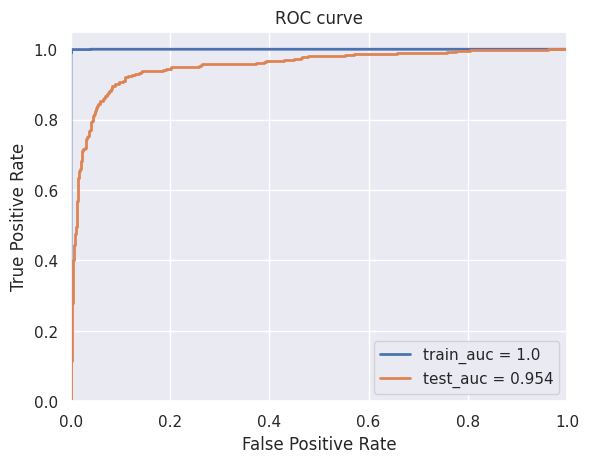



TN_result:  [737 739 717 734 737]  TN_mean:  733
FP_result:  [25 23 45 27 24]  FP_result:  29
FN_result:  [73 51 44 74 57]  FN_result:  60
TP_result:  [157 179 186 156 173]  TP_result:  170
accuracy: 0.9102822580645161
precision: 0.8542713567839196
sensitivity: 0.7391304347826086
specificity: 0.9619422572178478
MCC: 0.7388245581453314




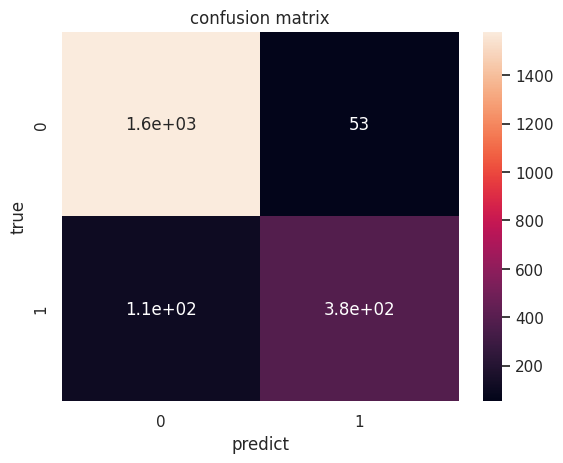

In [ ]:
svm = SVC(kernel = "rbf", C = svc_hyper["C"], gamma = svc_hyper["gamma"])
svc_model = BaggingClassifier(estimator=svm, n_estimators = 100)

plt.figure()
df_svc, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = model_evaluation_result(svc_xt, y_train, svc_xs, y_test, svc_model, 'train', 'test')
plt.show()

print("\n")
pointer(svc_model, svc_xt, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

# RF

In [ ]:
rf = RandomForestClassifier(n_jobs = -1)
RF = SGA(rf, x_pretrain_std, y_train)

In [ ]:
RF.build()
RF.printIndividual()
RF.set_mechanism()

Total no. of variables/length of each chromosome =  166
[1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0]


/usr/local/lib/python3.10/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
RF.sga()

gen	nevals	Mean    	Max     	Min     
0  	100   	0.948414	0.960855	0.931448
1  	58    	0.954588	0.961095	0.941395
2  	74    	0.958082	0.962547	0.943771
3  	67    	0.959312	0.962935	0.954319
4  	63    	0.960135	0.962951	0.956015
5  	60    	0.960543	0.964132	0.946079
6  	63    	0.961232	0.964132	0.956632
7  	70    	0.961732	0.964132	0.957491
8  	64    	0.962122	0.964132	0.958831
9  	56    	0.962595	0.964132	0.95957 
10 	72    	0.962789	0.964965	0.950497
11 	62    	0.963351	0.964965	0.961571
12 	56    	0.963616	0.964965	0.961675
13 	67    	0.963655	0.965524	0.959938
14 	53    	0.963869	0.965524	0.961002
15 	73    	0.96384 	0.965565	0.950986
16 	57    	0.964223	0.965696	0.960434
17 	63    	0.964122	0.965565	0.95078 
18 	62    	0.964347	0.966124	0.96134 
19 	61    	0.964539	0.966124	0.961858
20 	63    	0.964511	0.966297	0.961581
21 	73    	0.96421 	0.966297	0.959857
22 	63    	0.964471	0.966297	0.962342
23 	66    	0.96451 	0.966782	0.958693
24 	65    	0.964737	0.966848	0.953341
25 	60    	0

In [ ]:
#RF_feature = RF.find_feature() 35個
RF_feature = ['d6', 'd7', 'd8', 'd9', 'd14', 'd20', 'd28', 'd29', 'd32', 'd33', 'd39', 'c49', 'c55', 'c59', 'c60', 'c65', 'c66', 'c70', 'c72', 'c73', 'c83', 'c84', 'c86', 'c95', 'c98', 'c101', 'c102', 'c104', 'c106', 'c110', 'c115', 'c116', 'c131', 'c135', 'c137']

In [ ]:
rf_xt = x_pretrain_std.loc[:, RF_feature]
rf_xs = x_pretest_std.loc[:, RF_feature]

In [ ]:
def rf_function(n_estimators, max_depth, min_samples_leaf, min_samples_split):
    m = RandomForestClassifier(n_estimators = int(n_estimators), max_depth = int(max_depth), criterion = "gini", min_samples_leaf = int(min_samples_leaf), min_samples_split = int(min_samples_split))
    mean_score = cross_val_score(m, rf_xt, y_train, cv = 5, scoring = "roc_auc").mean()
    
    return mean_score

In [ ]:
pbounds = {
    'max_depth': [10, 70],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 8],
    'n_estimators': [100, 500]
}
rf_optimizer = BayesianOptimization(f = rf_function, pbounds = pbounds)

rf_optimizer.maximize(n_iter = 300)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.933     | 16.44     | 3.225     | 2.751     | 126.0     |
| 2         | 0.9355    | 52.64     | 3.431     | 7.726     | 139.8     |
| 3         | 0.9294    | 23.05     | 4.526     | 6.884     | 184.2     |
| 4         | 0.9309    | 69.37     | 4.562     | 2.239     | 465.0     |
| 5         | 0.9272    | 16.78     | 4.665     | 7.344     | 313.5     |
| 6         | 0.9565    | 55.84     | 1.956     | 3.41      | 116.4     |
| 7         | 0.9568    | 57.18     | 1.226     | 3.516     | 116.6     |
| 8         | 0.9252    | 67.12     | 5.0       | 8.0       | 100.0     |
| 9         | 0.9587    | 56.4      | 1.0       | 2.0       | 124.5     |
| 10        | 0.9456    | 69.44     | 2.363     | 2.027     | 127.1     |
| 11        | 0.959     | 42.34     | 1.338     | 2.314     | 120.9     |
| 12        | 0.9585    | 32.99     | 

In [ ]:
rf_optimizer.max

{'target': 0.9606646929517744,
 'params': {'max_depth': 59.07218871119701,
  'min_samples_leaf': 1.0,
  'min_samples_split': 2.0,
  'n_estimators': 256.77836666489344}}

              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     1.000        1.000        0.999  0.999  1.000  1.000
Test_set         0.918        0.963        0.767  0.762  0.863  0.932


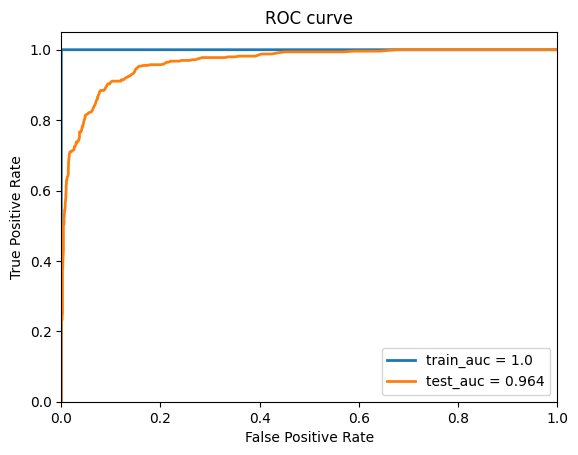



TN_result:  [734 729 721 730 733]  TN_mean:  729
FP_result:  [28 33 41 31 28]  FP_result:  32
FN_result:  [45 47 36 53 47]  FN_result:  46
TP_result:  [185 183 194 177 183]  TP_result:  184
accuracy: 0.9212916246215943
precision: 0.8518518518518519
sensitivity: 0.8
specificity: 0.9579500657030223
MCC: 0.7750310723968169




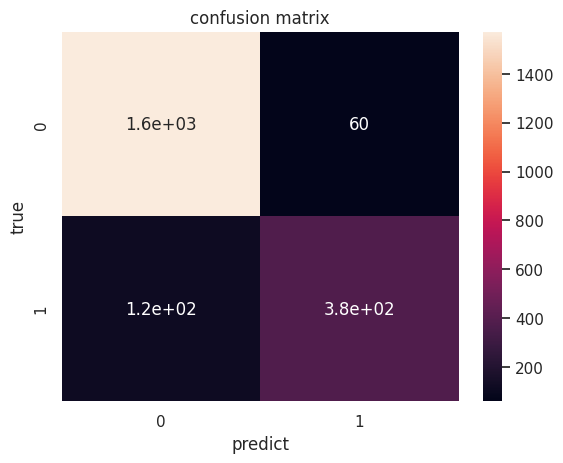

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 256, max_depth = 59, criterion = "gini", min_samples_leaf = 1, min_samples_split = 2)

plt.figure()
df_rf, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(rf_xt, y_train, rf_xs, y_test, rf_model, 'train', 'test')
plt.show()

print("\n")
pointer(rf_model, rf_xt, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

# XGB

In [ ]:
xgbc = XGBClassifier(n_jobs = -1, tree_method = 'gpu_hist')
xgb = SGA(xgbc, x_pretrain_std, y_train)

In [ ]:
xgb.build()
xgb.printIndividual()
xgb.set_mechanism()

Total no. of variables/length of each chromosome =  166
[1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]


In [ ]:
xgbc = XGBClassifier(n_jobs = -1, tree_method = 'gpu_hist')
xgb = SGA(xgbc, x_pretrain_std, y_train)

In [ ]:
xgb.build()
xgb.printIndividual()
xgb.set_mechanism()

Total no. of variables/length of each chromosome =  166
[1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]


In [ ]:
xgb.sga()

gen	nevals	Mean   	Max     	Min    
0  	100   	0.94494	0.961444	0.91027
1  	76    	0.955715	0.961646	0.925659
2  	71    	0.958479	0.963246	0.928674
3  	58    	0.95971 	0.963385	0.954032
4  	64    	0.960442	0.96406 	0.942351
5  	65    	0.961117	0.96366 	0.957109
6  	62    	0.961611	0.965147	0.944749
7  	64    	0.961683	0.965147	0.946799
8  	63    	0.962386	0.965147	0.95875 
9  	64    	0.962652	0.965147	0.959023
10 	70    	0.962675	0.965147	0.958911
11 	62    	0.96274 	0.965691	0.951091
12 	66    	0.9631  	0.965927	0.958931
13 	59    	0.963707	0.965927	0.952538
14 	69    	0.96367 	0.965927	0.959699
15 	66    	0.964148	0.965927	0.954517
16 	63    	0.964538	0.966184	0.960909
17 	69    	0.964432	0.966184	0.954845
18 	70    	0.964414	0.966184	0.960404
19 	74    	0.964854	0.966184	0.961639
20 	73    	0.965145	0.966184	0.953552
21 	64    	0.965452	0.966184	0.961591
22 	60    	0.965271	0.966184	0.959632
23 	70    	0.965141	0.966224	0.961384
24 	62    	0.965104	0.966224	0.954733
25 	75    	0.964

In [ ]:
#xgb_feature = xgb.find_feature() 51個
xgb_feature = ['d3', 'd5', 'd9', 'd14', 'd15', 'd20', 'd21', 'd22', 'd23', 'd27', 'd28', 'd31', 'd32', 'd37', 'd39', 'c47', 'c49', 'c50', 'c51', 'c53', 'c55', 'c57', 'c58', 'c59', 'c60', 'c62', 'c64', 'c65', 'c72', 'c73', 'c75', 'c78', 'c80', 'c84', 'c86', 'c90', 'c98', 'c100', 'c101', 'c102', 'c110', 'c111', 'c115', 'c117', 'c123', 'c129', 'c131', 'c133', 'c134', 'c137', 'c141']

No. of variables select =  51
['d3', 'd5', 'd9', 'd14', 'd15', 'd20', 'd21', 'd22', 'd23', 'd27', 'd28', 'd31', 'd32', 'd37', 'd39', 'c47', 'c49', 'c50', 'c51', 'c53', 'c55', 'c57', 'c58', 'c59', 'c60', 'c62', 'c64', 'c65', 'c72', 'c73', 'c75', 'c78', 'c80', 'c84', 'c86', 'c90', 'c98', 'c100', 'c101', 'c102', 'c110', 'c111', 'c115', 'c117', 'c123', 'c129', 'c131', 'c133', 'c134', 'c137', 'c141']


In [ ]:
xgb_xt = x_pretrain_std.loc[:, xgb_feature]
xgb_xs = x_pretest_std.loc[:, xgb_feature]

In [ ]:
def xgb_function(n_estimators, max_depth, learning_rate, gamma):
    m = XGBClassifier(n_estimators = int(n_estimators), max_depth = int(max_depth), learning_rate = learning_rate, gamma = gamma, tree_method = 'gpu_hist')
    mean_score = cross_val_score(m, xgb_xt, y_train, cv = 5, scoring = "roc_auc").mean()
    
    return mean_score

In [ ]:
pbounds = {
    'n_estimators':[100, 500],
    'max_depth': [10, 60],
    'learning_rate': [0.01, 3],
    'gamma': [0.015625, 128]
}
xgb_optimizer = BayesianOptimization(f = xgb_function, pbounds = pbounds)

xgb_optimizer.maximize(n_iter = 100)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.8271    | 46.58     | 0.07964   | 12.96     | 450.4     |
| 2         | 0.4743    | 112.0     | 2.582     | 10.02     | 300.0     |
| 3         | 0.4473    | 117.2     | 2.788     | 15.45     | 375.2     |
| 4         | 0.5088    | 41.02     | 2.641     | 23.6      | 188.6     |
| 5         | 0.5437    | 11.85     | 2.411     | 18.78     | 485.2     |
| 6         | 0.8216    | 46.29     | 0.8575    | 14.49     | 446.5     |
| 7         | 0.8235    | 84.32     | 0.01      | 14.41     | 460.7     |
| 8         | 0.8197    | 108.1     | 0.01      | 60.0      | 500.0     |
| 9         | 0.8197    | 127.4     | 0.79      | 19.8      | 498.2     |
| 10        | 0.8006    | 128.0     | 0.01      | 60.0      | 100.0     |
| 11        | 0.8171    | 85.75     | 0.5941    | 10.61     | 100.5     |
| 12        | 0.8235    | 38.88     | 

In [ ]:
xgb_hyper = xgb_optimizer.max["params"]

              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     0.998        0.999        0.993  0.993  0.997  0.998
Test_set         0.935        0.960        0.850  0.815  0.866  0.955


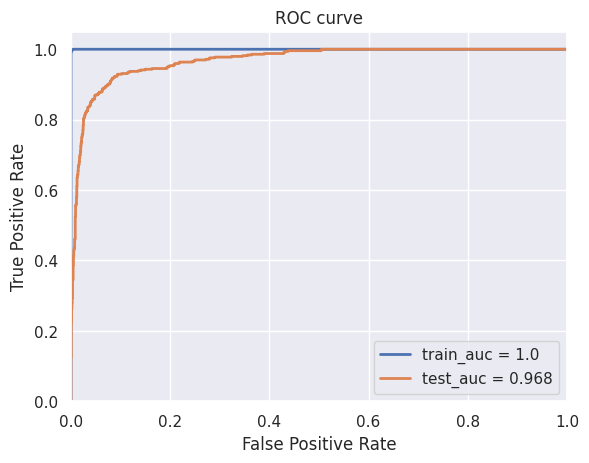



TN_result:  [737 733 715 732 729]  TN_mean:  729
FP_result:  [25 29 47 29 32]  FP_result:  32
FN_result:  [44 37 31 49 45]  FN_result:  41
TP_result:  [186 193 199 181 185]  TP_result:  189
accuracy: 0.9263370332996973
precision: 0.8552036199095022
sensitivity: 0.8217391304347826
specificity: 0.9579500657030223
MCC: 0.7907446520245783




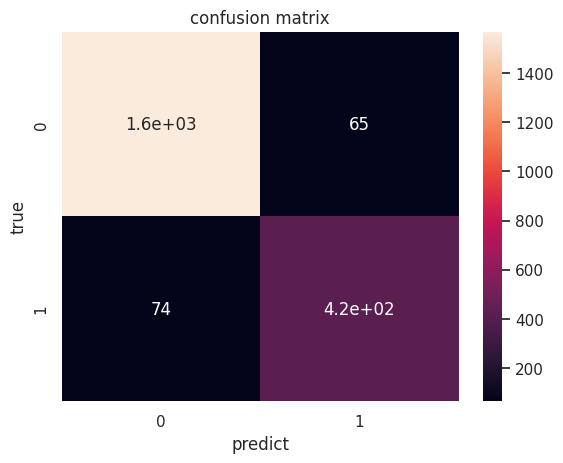

In [ ]:
xgb_model = XGBClassifier(gamma = xgb_hyper["gamma"], learning_rate = xgb_hyper["learning_rate"], max_depth = int(xgb_hyper["max_depth"]), n_estimators = int(xgb_hyper["n_estimators"]))

plt.figure()
df_xgb, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(xgb_xt, y_train, xgb_xs, y_test, xgb_model, 'train', 'test')
plt.show()

print("\n")
pointer(xgb_model, xgb_xt, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

# **Feature importance**

In [ ]:
def rfe(model, x_train, y_train):
  rfecv = RFECV(estimator = model, step = 1, cv = 5, scoring='roc_auc').fit(x_train, y_train)
  print("Optimal number of features : %d" % rfecv.n_features_)
  print("Support is %s" % rfecv.support_)
  print("Ranking of features : %s" % rfecv.ranking_)

  return rfecv.n_features_, rfecv.support_

# SVC

In [ ]:
permut_model = cuSVC(kernel = "rbf").fit(x_pretrain_std, y_train)

perm = permutation_importance(permut_model, x_pretrain_std, y_train, n_repeats = 5, scoring = "roc_auc", random_state=0)

In [ ]:
importance = pd.DataFrame({
    "importances_mean": perm['importances_mean']
})

importance.index = x_pretrain_std.columns

In [ ]:
svc_prefeature = x_pretrain_std.loc[:, importance[importance["importances_mean"] != 0].index]
svc_test_prefeature = x_pretest_std.loc[:, importance[importance["importances_mean"] != 0].index]

threshold = importance[importance["importances_mean"] != 0].sort_values(by="importances_mean", ascending=True)
importance = importance[importance["importances_mean"] != 0]

best_threshold:  0.0035495524296676128
best_score:  0.8720550582779735


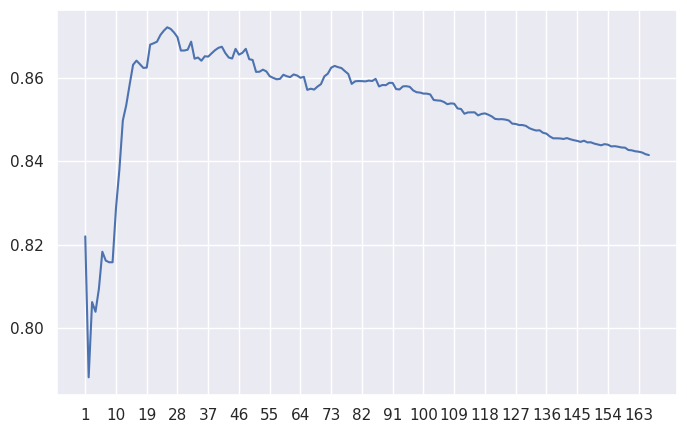

In [ ]:
score = []
best_threshold = 0
best_score = 0

for i in threshold.iloc[:,0]:
  temp_feature = svc_prefeature.loc[:, importance[importance["importances_mean"] >= i].index]
  temp_svc = cuSVC(kernel = "rbf").fit(temp_feature, y_train)
  mean_score = cross_val_score(temp_svc, temp_feature, y_train, cv = 5, scoring = "roc_auc").mean()
  score.append(mean_score)
  if(mean_score > best_score):
    best_score = mean_score
    best_threshold = i

max = len(threshold)
score.reverse()
print("best_threshold: ", best_threshold)
print("best_score: ", best_score)
plt.figure(figsize = (8, 5))
plt.plot(range(1, max+1), score)
plt.xticks(range(1, max+1, 9))
plt.show()

In [ ]:
svc_xt = svc_prefeature.loc[:, importance[importance["importances_mean"] >= best_threshold].index]
svc_xs = svc_test_prefeature.loc[:, importance[importance["importances_mean"] >= best_threshold].index]

#print(svc_xt.columns) #25個 ['d8', 'd9', 'd22', 'c55', 'c62', 'c73', 'c108', 'c110', 'c113', 'c117', 'c124', 'c148', 'c160', 'c169', 'c173', 'c175', 'c214', 'c217', 'c225', 'c268', 'c273', 'c277', 'c281', 'c501', 'c502']

In [ ]:
def svc_function(C, gamma):
    m = cuSVC(kernel = "rbf", C = C, gamma = gamma)
    mean_score = cross_val_score(m, svc_xt, y_train, cv = 5, scoring = "roc_auc").mean()
    
    return mean_score

In [ ]:
pbounds = {
    'C': [0.0078125, 256],
    'gamma': [0.0078125, 256]
}
svc_optimizer = BayesianOptimization(f = svc_function, pbounds = pbounds)

svc_optimizer.maximize(n_iter = 300)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | 0.916     | 237.7     | 18.58     |
| 2         | 0.7258    | 141.5     | 137.7     |
| 3         | 0.7365    | 178.4     | 127.2     |
| 4         | 0.8336    | 197.9     | 59.93     |
| 5         | 0.9245    | 218.3     | 12.79     |
| 6         | 0.8389    | 0.007812  | 0.007812  |
| 7         | 0.6167    | 0.007812  | 256.0     |
| 8         | 0.9169    | 237.0     | 17.99     |
| 9         | 0.8966    | 129.7     | 0.007812  |
| 10        | 0.9054    | 256.0     | 0.007812  |
| 11        | 0.6377    | 256.0     | 256.0     |
| 12        | 0.9013    | 186.8     | 0.007812  |
| 13        | 0.8859    | 70.7      | 0.007812  |
| 14        | 0.7695    | 0.007812  | 84.16     |
| 15        | 0.9038    | 223.9     | 0.007812  |
| 16        | 0.8611    | 99.25     | 47.13     |
| 17        | 0.903     | 159.3     | 26.42     |
| 18        | 0.9121    | 194.8     | 22.11     |


In [ ]:
svc_hyper = svc_optimizer.max["params"]

              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     1.000        1.000        0.999  0.999  0.999  1.000
Test_set         0.915        0.977        0.710  0.750  0.902  0.918


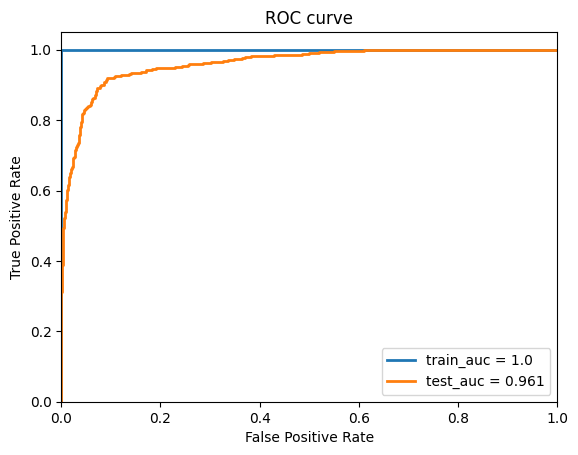



TN_result:  [745 751 737 743 741]  TN_mean:  743
FP_result:  [17 11 25 18 20]  FP_result:  18
FN_result:  [89 72 92 90 84]  FN_result:  85
TP_result:  [141 158 138 140 146]  TP_result:  145
accuracy: 0.8960645812310797
precision: 0.8895705521472392
sensitivity: 0.6304347826086957
specificity: 0.9763469119579501
MCC: 0.6910027031192049




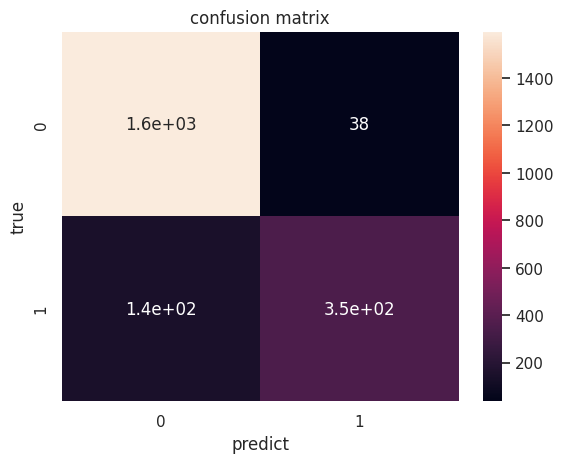

In [ ]:
svm = SVC(kernel = "rbf", C = svc_hyper["C"], gamma = svc_hyper["gamma"])
svc_model = BaggingClassifier(estimator=svm, n_estimators = 100)

plt.figure()
df_svc, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = model_evaluation_result(svc_xt, y_train, svc_xs, y_test, svc_model, 'train', 'test')
plt.show()

print("\n")
pointer(svc_model, svc_xt, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

# RF

In [ ]:
rf = RandomForestClassifier()
n_feature, selected = rfe(rf, x_pretrain_std, y_train)

Optimal number of features : 15
Support is [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False  True False False False False False
 False False False False False False  True  True False False False False
 False False False False  True  True  True False  True False  True False
 False False  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False F

In [ ]:
rf_xt = x_pretrain_std.loc[:, selected]
rf_xs = x_pretest_std.loc[:, selected]

#print(rf_xt.columns) 15個 ['c59', 'c73', 'c110', 'c124', 'c146', 'c147', 'c159', 'c160', 'c161', 'c164', 'c167', 'c173', 'c174', 'c175', 'c277']

Index(['c59', 'c73', 'c110', 'c124', 'c146', 'c147', 'c159', 'c160', 'c161',
       'c164', 'c167', 'c173', 'c174', 'c175', 'c277'],
      dtype='object')


In [ ]:
def rf_function(n_estimators, max_depth, min_samples_leaf, min_samples_split):
    m = RandomForestClassifier(n_estimators = int(n_estimators), max_depth = int(max_depth), criterion = "gini", min_samples_leaf = int(min_samples_leaf), min_samples_split = int(min_samples_split))
    mean_score = cross_val_score(m, rf_xt, y_train, cv = 5, scoring = "roc_auc").mean()
    
    return mean_score

In [ ]:
pbounds = {
    'max_depth': [10, 70],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 8],
    'n_estimators': [100, 500]
}
rf_optimizer = BayesianOptimization(f = rf_function, pbounds = pbounds)

rf_optimizer.maximize(n_iter = 300)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9525    | 60.24     | 3.314     | 2.765     | 111.4     |
| 2         | 0.9467    | 54.67     | 4.662     | 6.815     | 297.2     |
| 3         | 0.9528    | 27.99     | 3.094     | 7.843     | 479.9     |
| 4         | 0.9527    | 66.21     | 3.439     | 7.84      | 386.3     |
| 5         | 0.9471    | 47.87     | 4.727     | 5.844     | 322.0     |
| 6         | 0.9475    | 69.33     | 4.708     | 2.339     | 442.8     |
| 7         | 0.9232    | 11.29     | 4.597     | 2.885     | 498.3     |
| 8         | 0.9648    | 60.58     | 1.825     | 3.333     | 112.0     |
| 9         | 0.9625    | 59.02     | 1.205     | 5.224     | 113.1     |
| 10        | 0.9614    | 61.8      | 1.479     | 5.63      | 113.2     |
| 11        | 0.9663    | 60.35     | 1.507     | 3.038     | 117.2     |
| 12        | 0.9672    | 64.49     | 

In [ ]:
rf_hyper = rf_optimizer.max["params"]

              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     1.000        1.000        1.000  1.000  1.000  1.000
Test_set         0.936        0.975        0.805  0.814  0.906  0.943


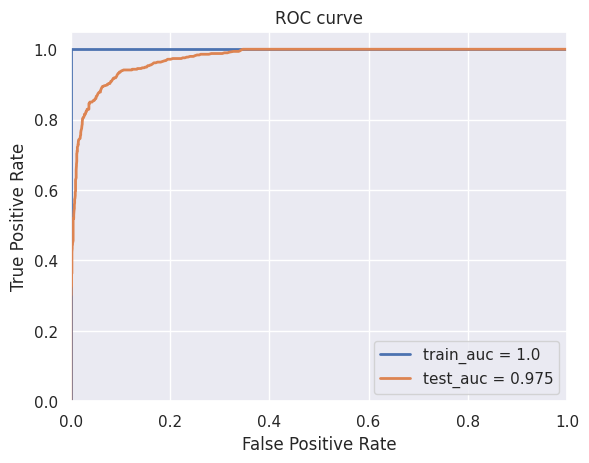



TN_result:  [735 734 739 738 743]  TN_mean:  738
FP_result:  [27 28 23 23 18]  FP_result:  24
FN_result:  [58 60 50 66 49]  FN_result:  57
TP_result:  [172 170 180 164 181]  TP_result:  173
accuracy: 0.9183467741935484
precision: 0.8781725888324873
sensitivity: 0.7521739130434782
specificity: 0.968503937007874
MCC: 0.7623701799091263




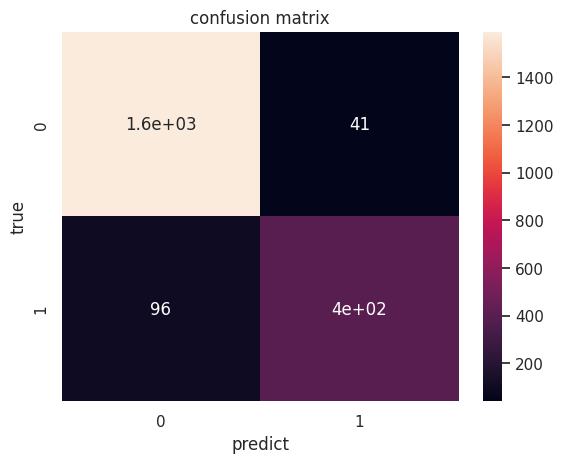

In [ ]:
rf_model = RandomForestClassifier(n_estimators = int(rf_hyper["n_estimators"]), max_depth = int(rf_hyper["max_depth"]), criterion = "gini", min_samples_leaf = int(rf_hyper["min_samples_leaf"]), min_samples_split = int(rf_hyper["min_samples_split"]))

plt.figure()
df_rf, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(rf_xt, y_train, rf_xs, y_test, rf_model, 'train', 'test')
plt.show()

print("\n")
pointer(rf_model, rf_xt, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

# XGB

In [ ]:
xgb = XGBClassifier()
n_feature, selected = rfe(xgb, x_pretrain_std, y_train)

Optimal number of features : 70
Support is [False  True False  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False  True False  True
  True  True  True  True  True  True  True False  True  True  True False
  True  True  True False  True False False False False False False False
  True False False False False False False False  True  True  True  True
 False False False False  True  True  True False False False False False
 False  True  True False False False  True False  True  True  True False
 False False False False  True  True False False False  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
 False  True  True False  True False False  True  True False  True  True
 False False False False  True  True  True  True False  True  True  True
 False False False False False False False False False False  True False
  True F

In [ ]:
xgb_xt = x_pretrain_std.loc[:, selected]
xgb_xs = x_pretest_std.loc[:, selected]

#print(xgb_xt.columns) 70個 
# 'd4', 'd6', 'd7', 'c49', 'c55', 'c57', 'c58', 'c59', 'c60', 'c62',
#        'c64', 'c65', 'c66', 'c71', 'c72', 'c73', 'c75', 'c78', 'c79', 'c82',
#        'c98', 'c110', 'c111', 'c113', 'c115', 'c122', 'c123', 'c124', 'c134',
#        'c135', 'c146', 'c148', 'c149', 'c151', 'c159', 'c160', 'c166', 'c167',
#        'c168', 'c169', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c179',
#        'c180', 'c181', 'c184', 'c186', 'c188', 'c192', 'c214', 'c217', 'c225',
#        'c228', 'c263', 'c268', 'c270', 'c273', 'c277', 'c279', 'c281', 'c365',
#        'c376', 'c501', 'c502', 'c503', 'c504']

Index(['d4', 'd6', 'd7', 'c49', 'c55', 'c57', 'c58', 'c59', 'c60', 'c62',
       'c64', 'c65', 'c66', 'c71', 'c72', 'c73', 'c75', 'c78', 'c79', 'c82',
       'c98', 'c110', 'c111', 'c113', 'c115', 'c122', 'c123', 'c124', 'c134',
       'c135', 'c146', 'c148', 'c149', 'c151', 'c159', 'c160', 'c166', 'c167',
       'c168', 'c169', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c179',
       'c180', 'c181', 'c184', 'c186', 'c188', 'c192', 'c214', 'c217', 'c225',
       'c228', 'c263', 'c268', 'c270', 'c273', 'c277', 'c279', 'c281', 'c365',
       'c376', 'c501', 'c502', 'c503', 'c504'],
      dtype='object')


In [ ]:
def xgb_function(n_estimators, max_depth, learning_rate, gamma):
    m = XGBClassifier(n_estimators = int(n_estimators), max_depth = int(max_depth), learning_rate = learning_rate, gamma = gamma, tree_method = 'gpu_hist')
    mean_score = cross_val_score(m, xgb_xt, y_train, cv = 5, scoring = "roc_auc").mean()
    
    return mean_score

In [ ]:
pbounds = {
    'n_estimators':[100, 500],
    'max_depth': [10, 60],
    'learning_rate': [0.01, 3],
    'gamma': [0.015625, 128]
}
xgb_optimizer = BayesianOptimization(f = xgb_function, pbounds = pbounds)

xgb_optimizer.maximize(n_iter = 300)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9547    | 1.752     | 0.2516    | 43.63     | 319.4     |
| 2         | 0.5631    | 26.15     | 2.853     | 16.43     | 101.3     |
| 3         | 0.8358    | 29.27     | 0.03721   | 48.67     | 344.0     |
| 4         | 0.5059    | 112.8     | 2.899     | 57.28     | 227.9     |
| 5         | 0.824     | 60.63     | 0.3757    | 35.75     | 464.8     |
| 6         | 0.8229    | 56.97     | 0.5017    | 36.86     | 465.3     |
| 7         | 0.5328    | 0.01562   | 3.0       | 10.0      | 270.9     |
| 8         | 0.9636    | 0.01562   | 0.01      | 16.74     | 348.9     |
| 9         | 0.962     | 0.7032    | 0.365     | 24.63     | 402.9     |
| 10        | 0.4971    | 128.0     | 3.0       | 10.0      | 401.0     |
| 11        | 0.5674    | 1.659     | 2.722     | 55.91     | 374.7     |
| 12        | 0.8613    | 16.55     | 

In [ ]:
xgb_hyper = xgb_optimizer.max["params"]

              Accuracy  Specificity  Sensitivity    MCC    PPV    NPV
Training set     1.000        1.000        1.000  1.000  1.000  1.000
Test_set         0.931        0.969        0.807  0.802  0.886  0.943


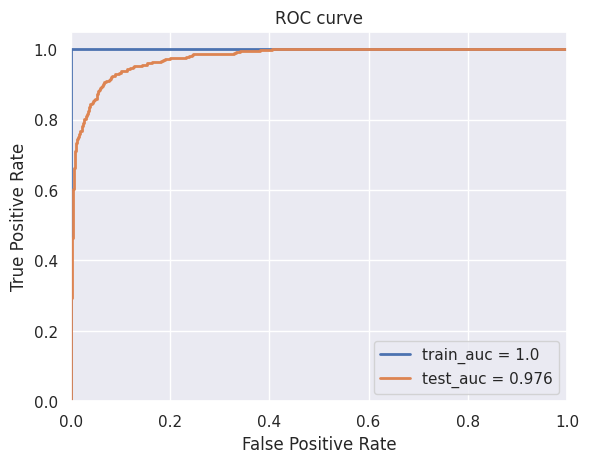



TN_result:  [738 734 726 736 733]  TN_mean:  733
FP_result:  [24 28 36 25 28]  FP_result:  28
FN_result:  [42 30 40 46 46]  FN_result:  41
TP_result:  [188 200 190 184 184]  TP_result:  189
accuracy: 0.9303733602421796
precision: 0.8709677419354839
sensitivity: 0.8217391304347826
specificity: 0.9632063074901446
MCC: 0.8013004171424416




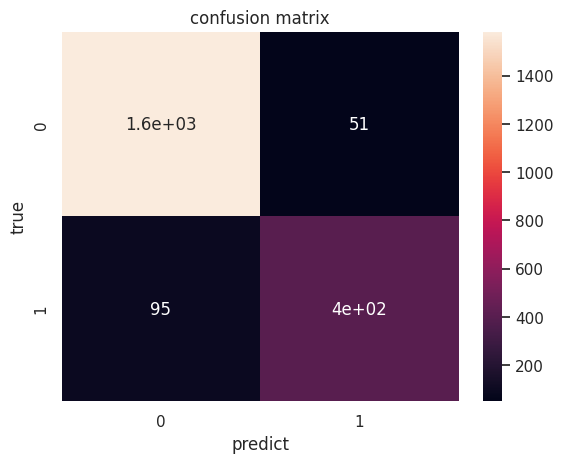

In [ ]:
xgb_model = XGBClassifier(gamma = xgb_hyper["gamma"], learning_rate = xgb_hyper["learning_rate"], max_depth = int(xgb_hyper["max_depth"]), n_estimators = int(xgb_hyper["n_estimators"]))

plt.figure()
df_xgb, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = proba_model_evaluation_result(xgb_xt, y_train, xgb_xs, y_test, xgb_model, 'train', 'test')
plt.show()

print("\n")
pointer(xgb_model, xgb_xt, y_train)
print("\n")
confusion_matrix_(y_test, te_predlabel)

# **selected Feature importance**

In [ ]:
selected = ['c59', 'c73', 'c110', 'c124', 'c146', 'c147', 'c159', 'c160', 'c161', 'c164', 'c167', 'c173', 'c174', 'c175', 'c277']

rf_xt = x_pretrain_std.loc[:, selected]
rf_xs = x_pretest_std.loc[:, selected]

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 406, max_depth = 39, criterion = "gini", min_samples_leaf = 1, min_samples_split = 2)

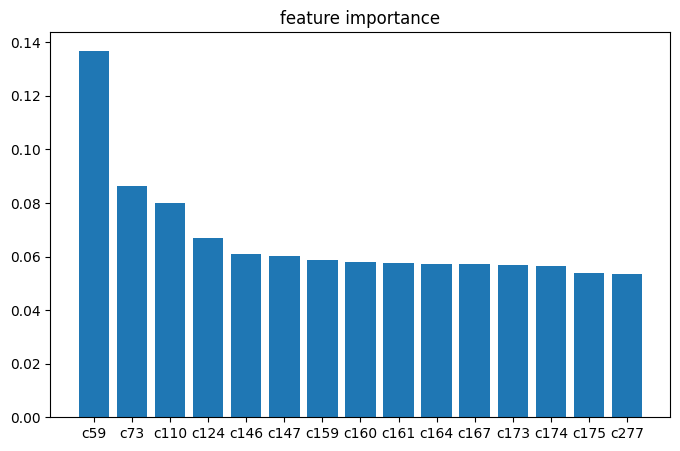

In [ ]:
rf_model.fit(rf_xt, y_train)
importances = rf_model.feature_importances_

indices = np.argsort(importances)[::-1]
feature = list(rf_xt.columns)

plt.figure(figsize = (8, 5))
plt.title("feature importance")
plt.bar(range(len(feature)), importances[indices])
plt.xticks(range(len(feature)), feature)
plt.show()

# **boostrap**

In [25]:
from sklearn.utils import resample

In [26]:
def booststrap(model, x_test, y_test, times):
  
  auc_tot = []
  mcc_tot = []
  acc_tot = []
  for i in range(times):
    x_re, y_re = resample(x_test, y_test, replace=True)
    pred = model.predict(x_re)
    score = model.predict_proba(x_re)
    tn, fp, fn, tp = confusion_matrix(y_re, pred).ravel()

    acc = accuracy_score(y_re, pred)
    MCC = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    fpr, tpr , _ = roc_curve(y_re, score[:, 1])
    roc_auc = auc(fpr, tpr)

    auc_tot.append(roc_auc)
    mcc_tot.append(MCC)
    acc_tot.append(acc)

  print_CI(acc_tot, times, "ACC")
  print_CI(mcc_tot, times, "MCC")
  print_CI(auc_tot, times, "AUC")

In [27]:
def print_CI(score, times, label):
  
  mean = sum(score)/len(score)
  median = np.percentile(score, 50)

  # get 95% interval
  alpha = 100-95
  lower_ci = np.percentile(score, alpha/2)
  upper_ci = np.percentile(score, 100-alpha/2)

  print(f"test set {times: d} bootstrap resamples: "
     f"Mean [{mean:.3f}], " 
     f"Median {label} [{median:.3f}]"
     f" with a 95% a confidence interval of [{lower_ci:.3f},{upper_ci:.3f}]")
  
  if(label == "AUC"):
    print("\n")
    get_CI_graph(score, times, label)

In [28]:
def get_CI_graph(score, times, label):

    alpha = 100-95
    lower_ci = np.percentile(score, alpha/2)
    upper_ci = np.percentile(score, 100-alpha/2)

    sns.kdeplot(score)
    plt.title(f"test set {times: d} bootstrap resamples\n"
          "showing median with 95% confidence intervals")
    plt.xlabel(label)
    plt.axvline(lower_ci,0, 14, linestyle="--", color="red")
    plt.axvline(upper_ci,0, 14, linestyle="--", color="red")
    plt.show()

rf

In [29]:
rf_feature = ['c59', 'c73', 'c110', 'c124', 'c146', 'c147', 'c159', 'c160', 'c161', 'c164', 'c167', 'c173', 'c174', 'c175', 'c277']
rf_xt = x_pretrain_std.loc[:, rf_feature]
rf_xs = x_pretest_std.loc[:, rf_feature]

rf_model = RandomForestClassifier(n_estimators = 406, max_depth = 39, criterion = "gini", min_samples_leaf = 1, min_samples_split = 2).fit(rf_xt, y_train)

test set  10000 bootstrap resamples: Mean [0.939], Median ACC [0.939] with a 95% a confidence interval of [0.929,0.949]
test set  10000 bootstrap resamples: Mean [0.824], Median MCC [0.824] with a 95% a confidence interval of [0.794,0.852]
test set  10000 bootstrap resamples: Mean [0.975], Median AUC [0.975] with a 95% a confidence interval of [0.969,0.981]




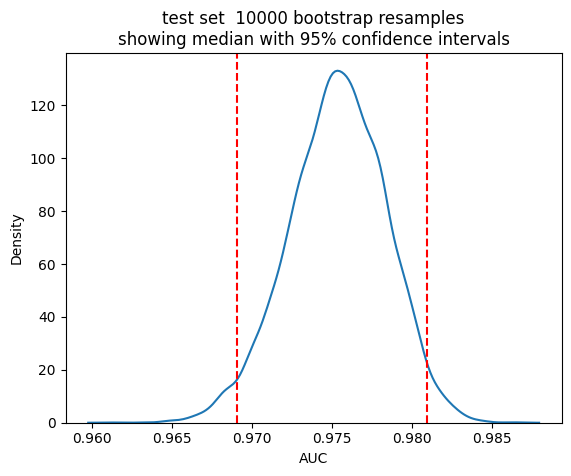

In [30]:
booststrap(rf_model, rf_xs, y_test, 10000)

xgb

In [31]:
xgb_feature = ['d4', 'd6', 'd7', 'c49', 'c55', 'c57', 'c58', 'c59', 'c60', 'c62',
       'c64', 'c65', 'c66', 'c71', 'c72', 'c73', 'c75', 'c78', 'c79', 'c82',
       'c98', 'c110', 'c111', 'c113', 'c115', 'c122', 'c123', 'c124', 'c134',
       'c135', 'c146', 'c148', 'c149', 'c151', 'c159', 'c160', 'c166', 'c167',
       'c168', 'c169', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c179',
       'c180', 'c181', 'c184', 'c186', 'c188', 'c192', 'c214', 'c217', 'c225',
       'c228', 'c263', 'c268', 'c270', 'c273', 'c277', 'c279', 'c281', 'c365',
       'c376', 'c501', 'c502', 'c503', 'c504']
xgb_xt = x_pretrain_std.loc[:, xgb_feature]
xgb_xs = x_pretest_std.loc[:, xgb_feature]

xgb_model = XGBClassifier(gamma = 0.03434, learning_rate = 0.1396, max_depth = 23, n_estimators = 323).fit(xgb_xt, y_train)

test set  10000 bootstrap resamples: Mean [0.932], Median ACC [0.932] with a 95% a confidence interval of [0.921,0.943]
test set  10000 bootstrap resamples: Mean [0.805], Median MCC [0.805] with a 95% a confidence interval of [0.774,0.835]
test set  10000 bootstrap resamples: Mean [0.975], Median AUC [0.975] with a 95% a confidence interval of [0.969,0.981]




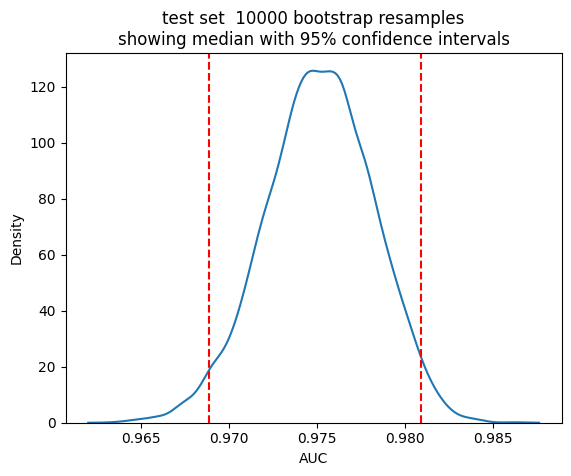

In [32]:
booststrap(xgb_model, xgb_xs, y_test, 10000)